In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))

## don't show warning
import warnings
warnings.filterwarnings('ignore')

## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

## for system
import glob
import os, sys
sys.path.append(os.path.expanduser("../lib"))
import EscalTools as et
from importlib import reload

/home/ghzuo/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## the data directory
filePref = os.path.expanduser('~/data/gromacs/') + "data.Hairpin/1le1/htSeed/MD-clst"

## the input trajs
trajs = range(0,len(glob.glob(filePref + "*.xtc")))

In [3]:
## The data per frames
skip = 1

### smooth
step    = 100
width   = 200
seg2vec = et.segment.medoid

### similar metrix
similar = et.dist.cosin

### evalute method
evalute = et.evalute.cluster

# RMSD from Native Structure

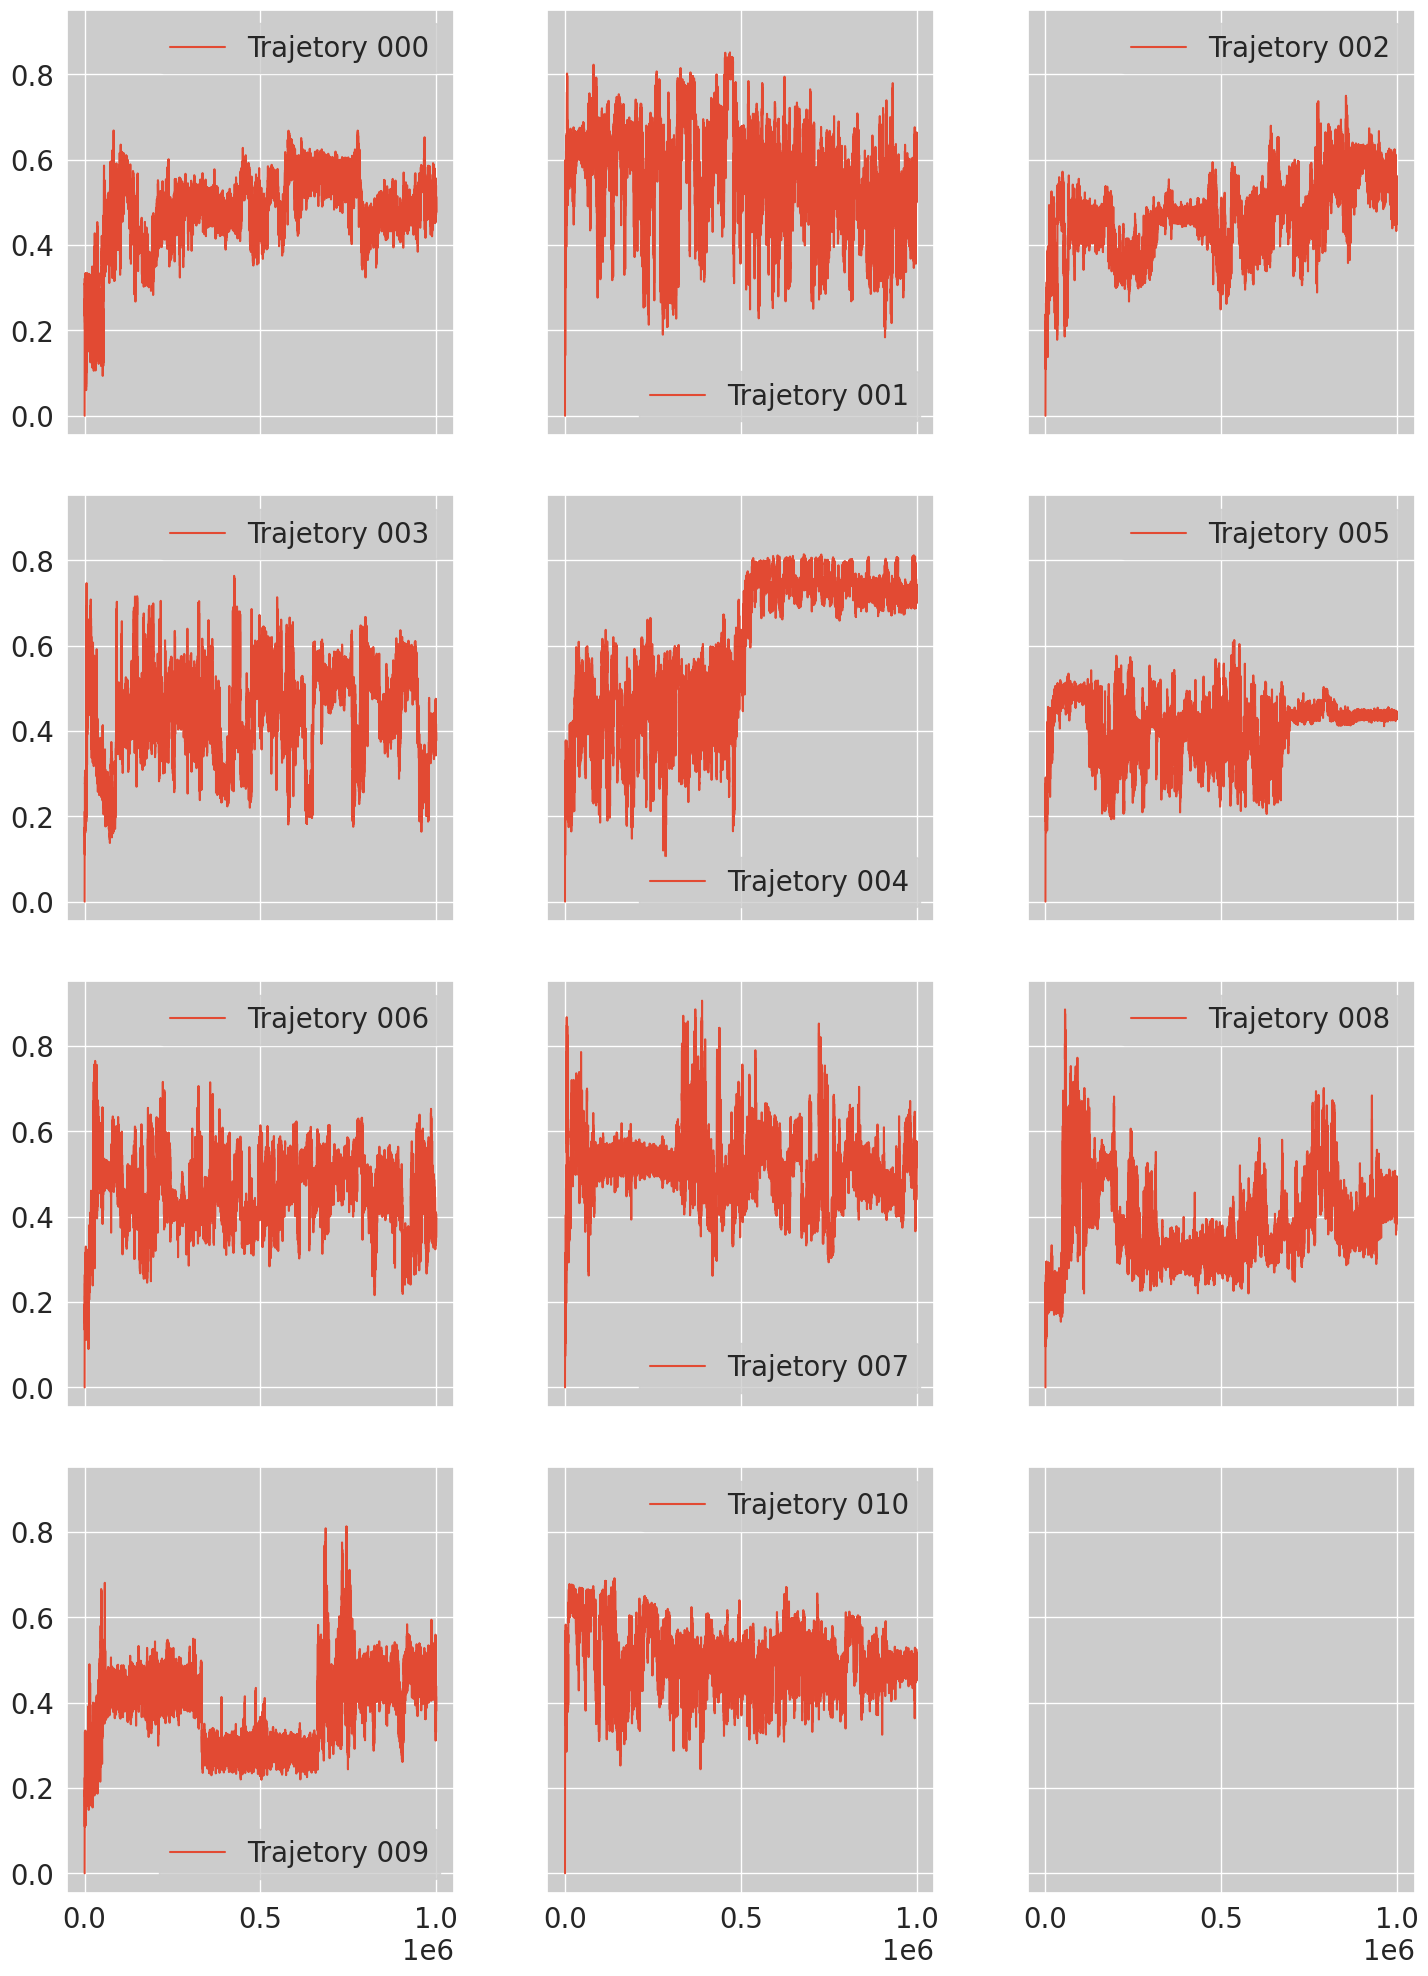

In [4]:
nrow = (len(trajs) - 1) // 3 + 1
fig, axs = plt.subplots(nrow,3,sharex=True,sharey=True,figsize=(15,5*nrow))
fig.tight_layout()
for ax,i in zip(axs.reshape(axs.size),trajs):
    fn = "{:s}{:03d}-CaRMS.xvg".format(filePref,i)
    rms = np.loadtxt(fn, comments=["@","#"]) 
    ax.plot(rms[:,0], rms[:,1], label="Trajetory {:03d}".format(i))
    ax.legend()

In [5]:
fig.savefig(filePref + "-CaRMS.pdf")

# Rescaling and Clustering

In [6]:
def testSC(n, Smat, Xs):
    cl = SpectralClustering(n_clusters=n, affinity='precomputed').fit_predict(Smat)
    return evalute(Xs, cl)

def tryCluster(Xv):
    Xs = seg2vec(Xv, step, width)
    Smat  = similar(Xs) 
    score = pd.DataFrame({'ncluster':np.arange(2,10)})
    score['score'] = score['ncluster'].apply(lambda n: testSC(n, Smat, Xs))
    idxPeak = score['score'].idxmax();
    return score.loc[idxPeak, :]

In [7]:
## read data from file
scores = {}
QMC = pd.DataFrame({'Trajectory Index':trajs, 
                    'Kappa':np.zeros(len(trajs)),
                    'Value':np.zeros(len(trajs))
                   }).set_index('Trajectory Index')
for i in trajs:
    ### the structure data
    fn = "{:s}{:03d}-rama.xvg".format(filePref,i)
    X = et.feature.dih2X(pd.DataFrame(np.loadtxt(fn, comments=["@","#"],
                             dtype = {'names': ('Phi', 'Psi', 'Residue'),
                                     'formats': ('f', 'f', 'S7')})))  
    # normaliztion
    X = np.array(X.loc[1::skip, :].reset_index(drop=True))

    ### read the energy
    fn = "{:s}{:03d}-potential.xvg".format(filePref,i)
    eng = pd.DataFrame(np.loadtxt(fn, comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))
    E  = np.array(eng.loc[1::skip, 'energy'])
    
    ### do the scaling
    scl = et.scaling.Efft(X, E)
    qmc = scl.check()
    QMC.loc[i,'Kappa'] = qmc['KappaMax']
    QMC.loc[i,'Value']   = qmc['qmcMax']
    
    ## get score
    scores["raw", i] = tryCluster(X)
    rescl = scl.rescale(qmc['KappaMax'])
    scores["scaled", i] = tryCluster(rescl['X'])

## Evalute by Rescaling

<AxesSubplot:xlabel='Trajectory Index'>

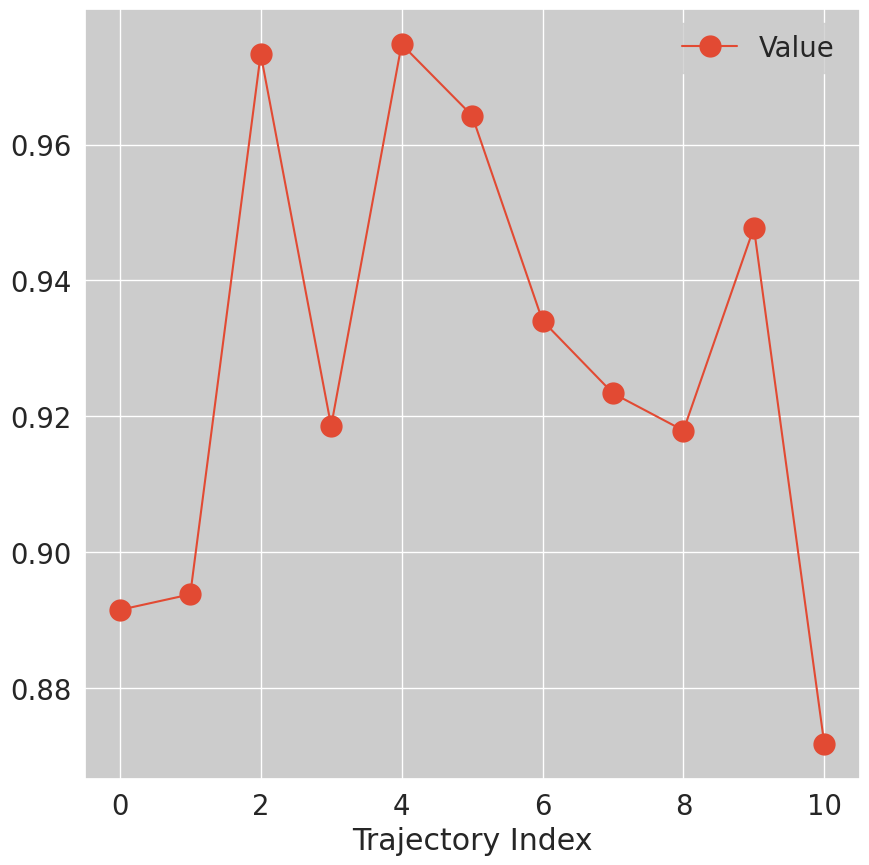

In [8]:
QMC.plot(y=["Value"], marker="o")

In [9]:
QMC

,Kappa,Value
Trajectory Index,,
0,6.0,0.891518
1,6.0,0.893804
2,2.0,0.973316
3,3.0,0.918572
4,6.0,0.974756
5,2.0,0.964263
6,3.0,0.934072
7,2.0,0.923388
8,3.0,0.917912


## Score of Clustering

In [10]:
## get the table
result = pd.DataFrame(scores).T.reset_index().pivot(
            index='level_1',columns='level_0', 
            values=['ncluster', 'score'])
result.columns = ["ncls raw", "ncls scale", "score raw", "score scaled"]
result.index.set_names(['Trajectory Index'], inplace=True)  

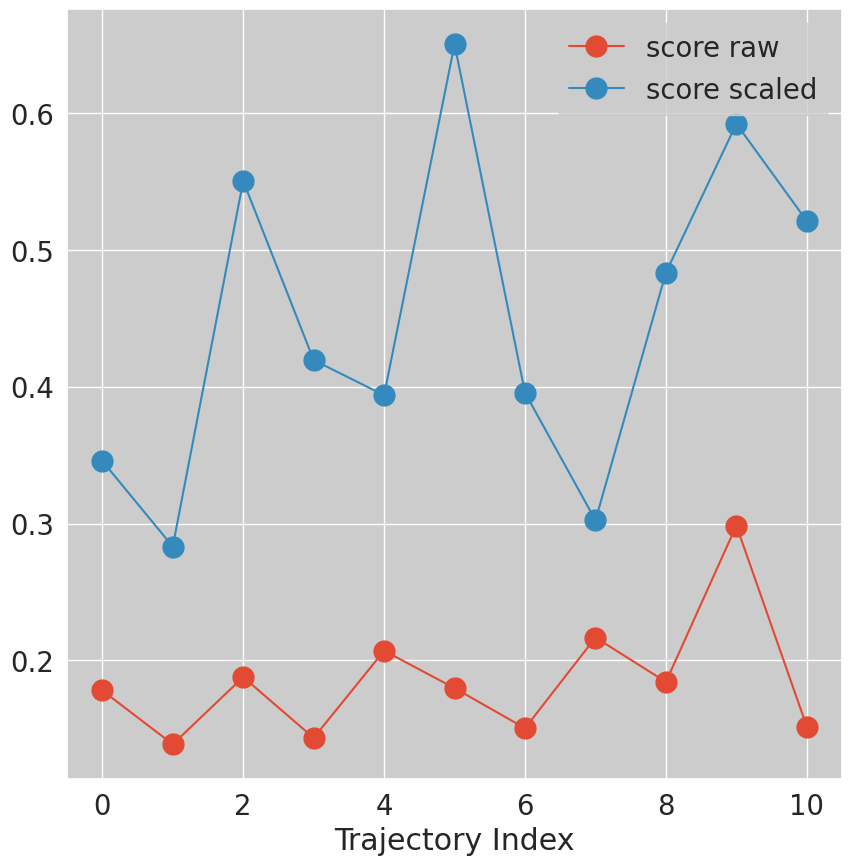

In [11]:
## plot data
result.plot(y=["score raw","score scaled"], marker="o")
fig.savefig(filePref + "-score.pdf")

In [12]:
result.to_csv(filePref + ".csv")
result

,ncls raw,ncls scale,score raw,score scaled
Trajectory Index,,,,
0,9.0,7.0,0.178039,0.345719
1,9.0,3.0,0.138752,0.283169
2,9.0,2.0,0.187807,0.550312
3,9.0,4.0,0.143404,0.419400
4,9.0,2.0,0.207078,0.393733
5,5.0,3.0,0.179738,0.650176
6,9.0,5.0,0.150477,0.395540
7,7.0,6.0,0.216724,0.302351
8,9.0,3.0,0.184288,0.483322
